### Time-dependent Problem

Here we extend the Laplace problem from the first example by a time variable. This leads to the heat equation:

\begin{align*}
    \partial_t u -0.1\Delta u &= 1.0 &&\text{ in } (0, 2) \times \Omega \\
    u &= 0 , &&\text{ on } (0, 2) \times \partial \Omega \\
    u(0, \cdot) &= 0 &&\text{ in } \Omega
\end{align*}

with $\Omega = (0, 1) \times (0, 1)$.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
if user <= 21: 
    gpu_device = str(user % 7) # moriarty
else: gpu_device = str(user % 4) # neptuno
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

In [ ]:

import torch
import math

Next we implement the *Spaces* that appear in the problem:

In [2]:
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')
T = tp.spaces.R1('t') # <- Add the time variable "t" of dimension 1

Now we define our domain. The space domain is already completed, here you have to create the time interval and the Cartesian product of both.

In [3]:
omega = tp.domains.Parallelogram(X, [0,0], [1,0], [0,1])
time_interval = tp.domains.Interval(T, 0, 2.0) # <-add the bounds of the Interval (0, 2)
product_domain = time_interval * omega # TODO: Create the product domain of time and space. Products are define with: *

Next we need to create some points, this is done by the *Sampler*. Here we need 3, one inside the domain, one for the boundary and one for the initial condition.

In [4]:
# Add the product domain of time and space:
inner_sampler = tp.samplers.RandomUniformSampler(product_domain, n_points=25000) 

# The boundary sampler is done already.
bound_sampler = tp.samplers.RandomUniformSampler(time_interval*omega.boundary, n_points=10000)

# Currently only the left interval side {0} is passed in the initial sampler, create the product domain with omega:
initial_sampler = tp.samplers.RandomUniformSampler(time_interval.boundary_left*omega, n_points=5000)

The neural network that learns the solution gets the time and space variable as an input and outputs the solution u. Add the correct spaces.

**Hint**: A product space is also defined with *

In [5]:
model = tp.models.FCN(input_space=T*X, output_space=U, hidden=(30,30,30))

Now, we have to transform our mathematical conditions given by our PDE into corresponding training conditions.

First we handle the PDE itself. Here, you have to finish the residual function.

In [6]:
def pde_residual(u, x, t):
    # TODO: Pass in the correct variables for the derivative computation 
    # as the second argument below:
    return tp.utils.grad(u, t) - 0.1*tp.utils.laplacian(u, x) - 1.0

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

The boundary condition is already done, since it is the same as in the first example.

In [7]:
def boundary_residual(u):
    return u 

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler, 
                                            boundary_residual, weight=50.0)

We now also need the initial condition. 

In [8]:
# Implement the residual for the initial condition:
def initial_residual(u):
    return u

initial_cond = tp.conditions.PINNCondition(model, initial_sampler, initial_residual) # add the model, sampler and residual

Before the training we collect all conditions and choose our training procedure:

In [9]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.005)
solver = tp.solver.Solver([pde_cond, boundary_cond, initial_cond], optimizer_setting=optim)

Start the training:

In [10]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=5000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We can plot the solution, for two different time points:

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

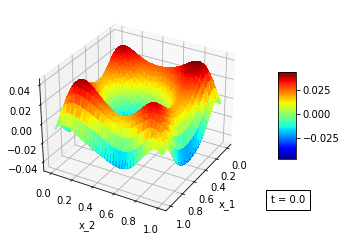

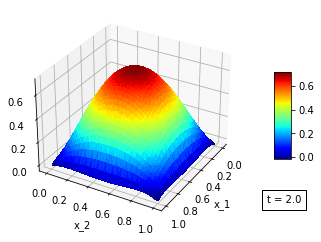

In [11]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 0.0})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)


plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 2.0})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)

MovieWriter ffmpeg unavailable; using Pillow instead.


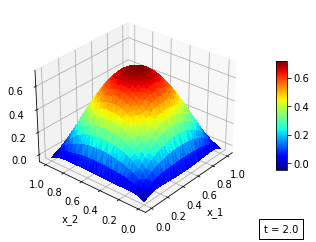

In [12]:
# We can also animate the solution over time
anim_sampler = tp.samplers.AnimationSampler(omega, time_interval, 200, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=10, angle=[30, 220])
anim.save('heat-eq.gif')
# You should be able to see a tab with a folder on the left side of your screen. There you can find the gif and can watch it.